<h1 align="center">AI in Signal & Audio</h1>
<h3 align="center">Identify your own voice!</h2>

<center>This notebook has been created by Justin AMINE</center>

<h4 style="font-size: 14px;">Some references that helped making this notebook:</h4>
<ul style="font-size: 12px;">
  <li><a href="https://www.kaggle.com/code/rajanmargaye/audio-mnist-with-lstm-auc-93">Kaggle Notebook: Audio MNIST with LSTM</a></li>
  <li><a href="https://towardsdatascience.com/voice-classification-using-deep-learning-with-python-6eddb9580381">Classification Notebook: Voice Classification Using Deep Learning with Python</a></li>
  <li><a href="https://www.youtube.com/watch?v=ZqpSb5p1xQo">YouTube Video: Audio Data Processing in Python</a></li>
  <li><a href="https://www.tensorflow.org/tutorials/audio/simple_audio">Tensorflow Tutorial: Simple Audio Recognition</a></li>
  <li><a href="https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505">Mel Spectorgram explained</a></li>
</ul>


## 1) Introduction

#### First, let's import all the libraries we need

In [1]:
import os
import keras
import joblib
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


Adjusting the pathes of our dataset (*folder is dataset/*)

In [2]:
DATA_PATH = "dataset/"
df=pd.DataFrame(columns=['raw_data','duration','speaker'])

Loading the dataset here, will go through each subdirectory (justin/kassem/abhi and retrieve the data found (.wav files here))

In [3]:
# Iterate over subdirectories
for subdirectory in os.listdir(DATA_PATH):
    subdirectory_path = os.path.join(DATA_PATH, subdirectory)
    
    if not os.path.isdir(subdirectory_path):
        continue  # Skip if not a subdirectory
    
    # Iterate over audio files in the subdirectory
    for filename in tqdm(os.listdir(subdirectory_path)):
        audio_path = os.path.join(subdirectory_path, filename)
        
        try:
            raw_data, frame_rate = librosa.load(audio_path)
            duration = len(raw_data) / frame_rate
            speaker = subdirectory  # subdirectory name is the speaker label
            
            df.loc[len(df)] = [raw_data, duration, speaker]
        except (PermissionError, FileNotFoundError) as e:
            print(f"Error loading file '{audio_path}': {str(e)}")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Visualizing the dataset (just checking)

In [4]:
df.head(2), df.tail(2)
#display(df)

(                                            raw_data  duration speaker
 0  [-3.08573e-06, -9.936893e-06, -2.9008079e-06, ...       3.0    abhi
 1  [-3.08573e-06, -9.936893e-06, -2.9008079e-06, ...       4.0    abhi,
                                              raw_data  duration speaker
 73  [-1.2170676e-07, -1.561278e-05, 1.5712767e-06,...       5.0  kassem
 74  [-1.2170676e-07, -1.561278e-05, 1.5712767e-06,...       5.0  kassem)

## 2) Some EDA here

These features represent the maximum, minimum, mean, and standard deviation of the amplitude of the audio signal, respectively.

In [5]:
df['max_amplitude'] = df['raw_data'].apply(np.max)
df['min_amplitude'] = df['raw_data'].apply(np.min)
df['mean_amplitude'] = df['raw_data'].apply(np.mean)
df['std_amplitude'] = df['raw_data'].apply(np.std)

Check the distribution of speakers in the dataset.

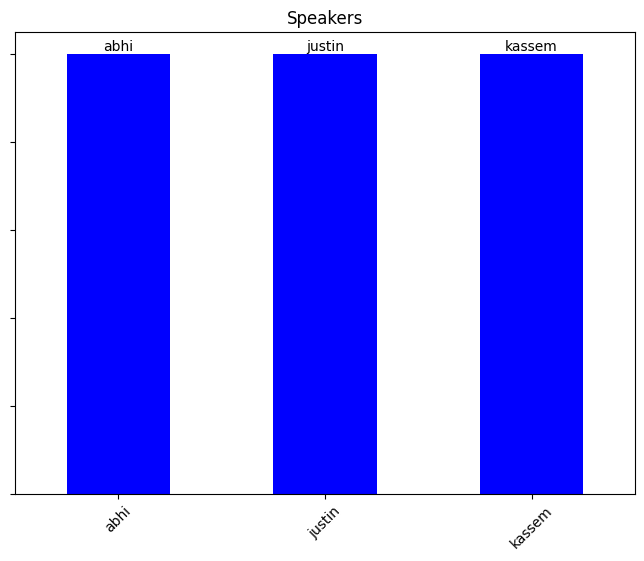

In [6]:
value_counts = df['speaker'].value_counts()

ax = value_counts.plot(kind='bar', figsize=(8, 6), color='blue')

ax.set_title('Speakers')
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='x', rotation=45)
ax.set_yticklabels('')
# Display the names inside the bars
for i, count in enumerate(value_counts):
    ax.text(i, count, value_counts.index[i], ha='center', va='bottom')

# Display the plot
plt.show()

Check the statistical summary of the numerical features.

In [7]:
df.describe()

,duration,max_amplitude,min_amplitude,mean_amplitude,std_amplitude
count,75.000000,75.000000,75.000000,7.500000e+01,75.000000
mean,5.133333,0.458137,-0.413921,1.057458e-07,0.051029
std,0.703914,0.332593,0.310854,8.009685e-06,0.041614
min,3.000000,0.007217,-1.023069,-3.084535e-05,0.000799
25%,5.000000,0.016029,-0.690345,-5.091335e-07,0.001776
50%,5.000000,0.609701,-0.486727,-4.941207e-08,0.051275
75%,5.000000,0.729136,-0.013066,3.796305e-07,0.087048
max,7.000000,1.018186,-0.008056,2.382768e-05,0.144122


Histograms of numerical features

array([[<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'max_amplitude'}>],
       [<Axes: title={'center': 'min_amplitude'}>,
        <Axes: title={'center': 'mean_amplitude'}>],
       [<Axes: title={'center': 'std_amplitude'}>, <Axes: >]],
      dtype=object)

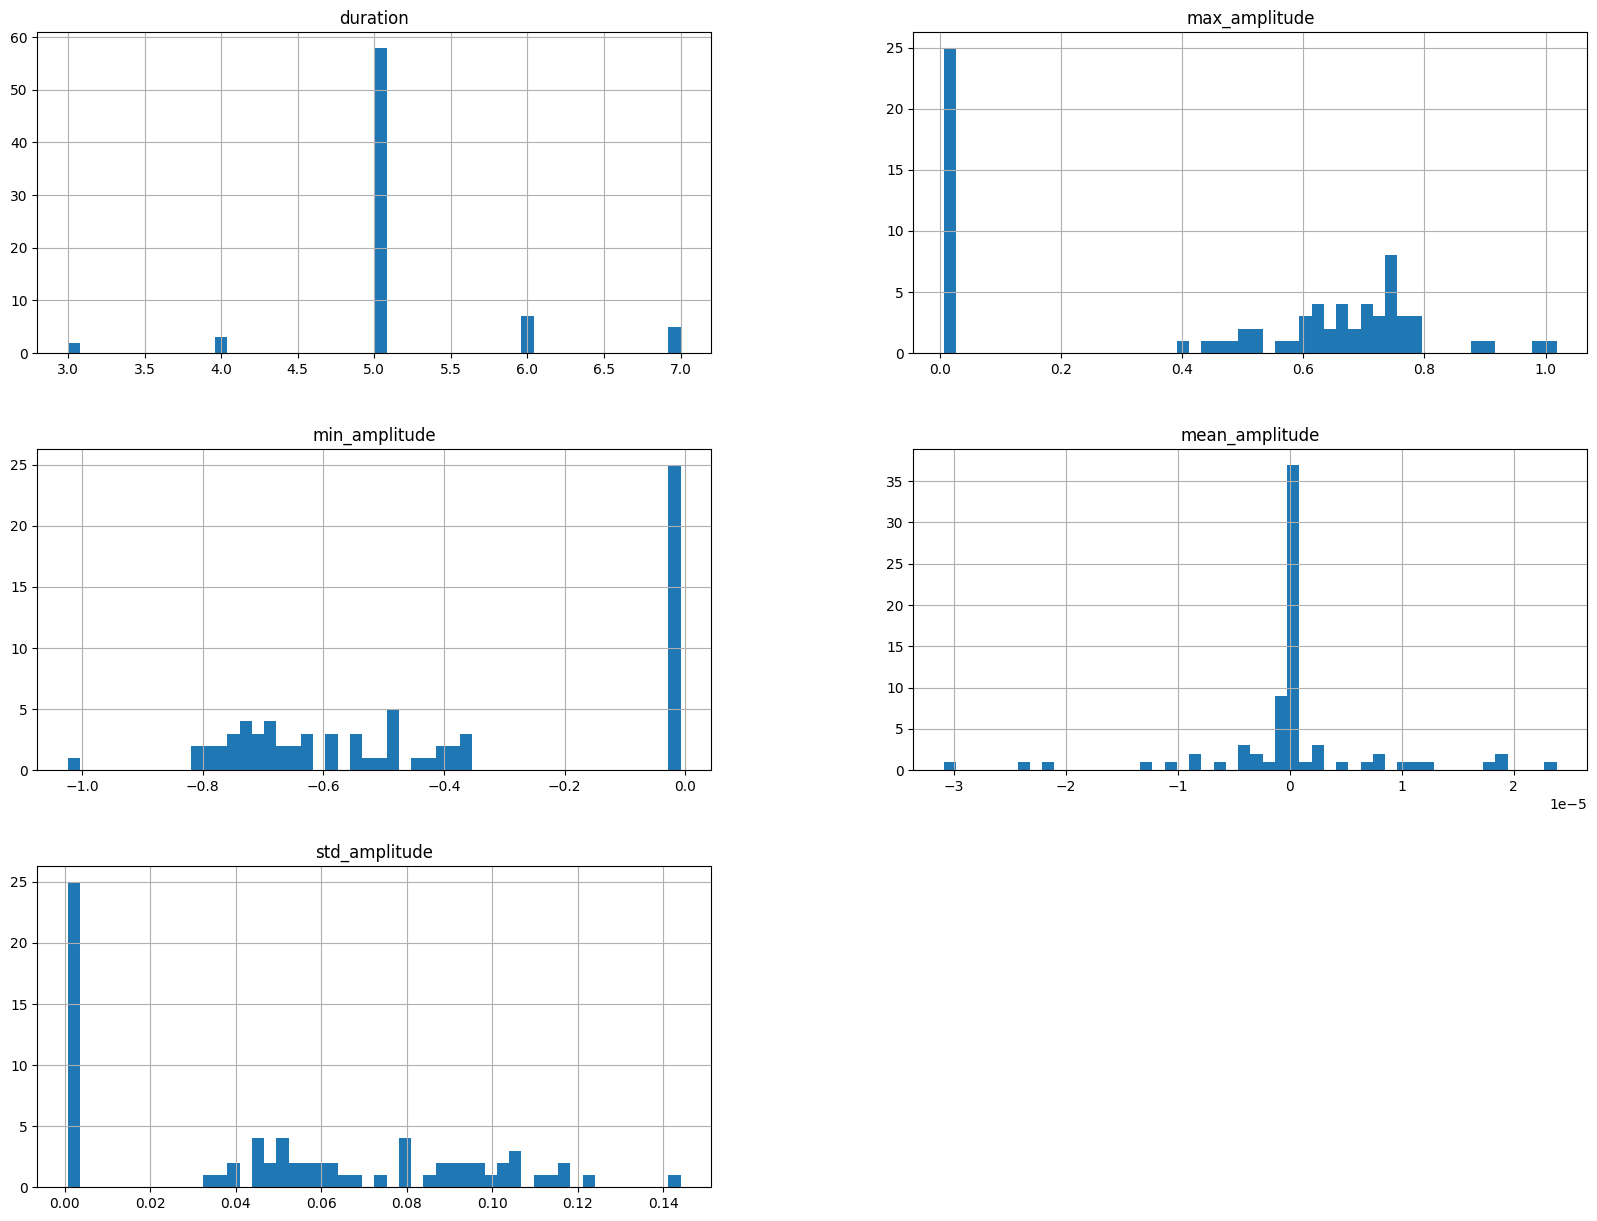

In [8]:
df[['duration', 'max_amplitude', 'min_amplitude', 'mean_amplitude', 'std_amplitude']].hist(bins=50, figsize=(20,15))

Let's plot the distribution of duration for each speaker to see if there are significant differences.

<Axes: xlabel='speaker', ylabel='duration'>

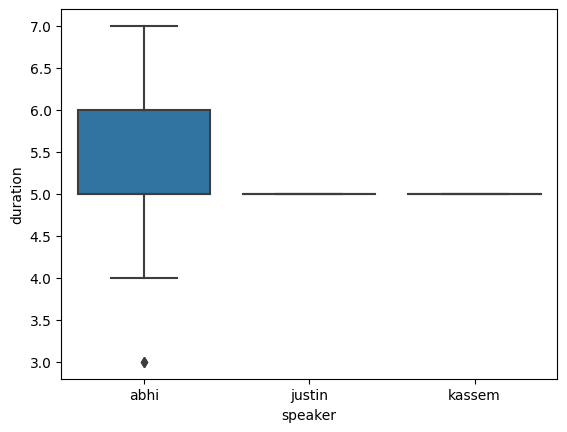

In [9]:
sns.boxplot(x="speaker", y="duration", data=df)

Now let's look at the amplitude features. We can use violin plots to visualize the distribution of these features for each speaker.

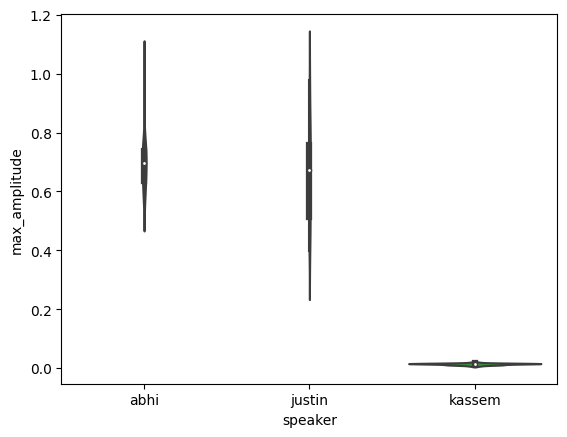

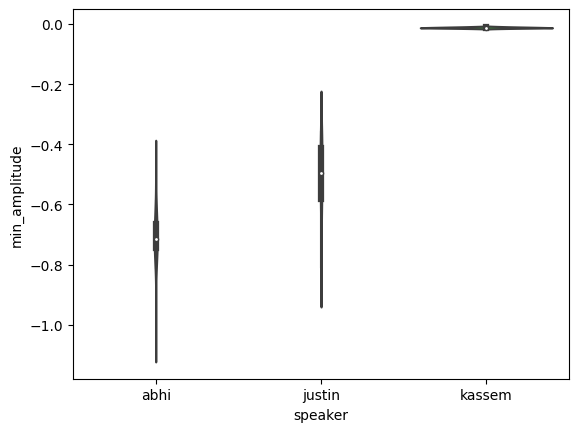

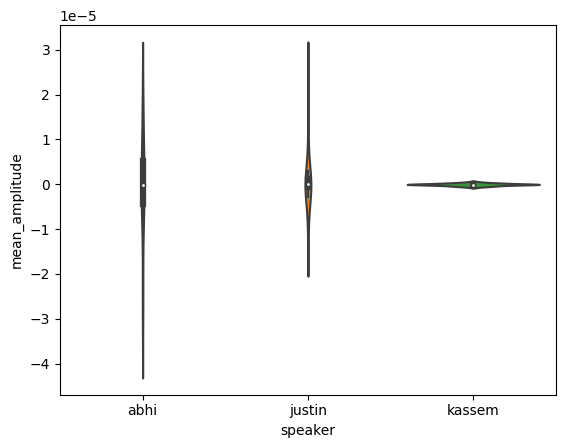

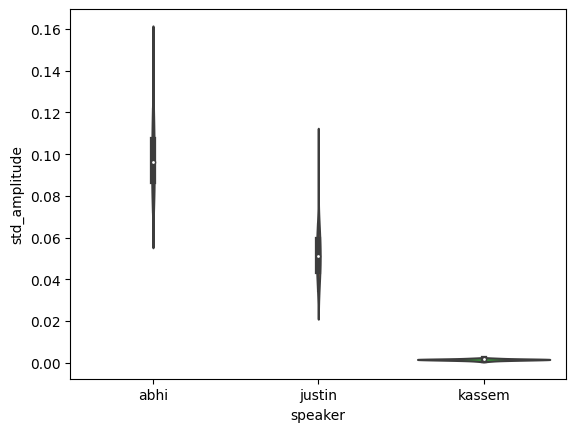

In [10]:
for col in ['max_amplitude', 'min_amplitude', 'mean_amplitude', 'std_amplitude']:
    sns.violinplot(x="speaker", y=col, data=df)
    plt.show()

**Feature extraction from raw audio data**<br>
We extracted multiple features from the raw audio data using the librosa library. This includes Mel-frequency cepstral coefficients (MFCC), Chroma feature, Spectral Contrast, and Tonnetz. Each of these features characterizes a different aspect of the audio data and might be useful in differentiating between the speakers.

In [11]:
def extract_features(raw_data, sr=22050):
    mfcc = librosa.feature.mfcc(y=raw_data, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=raw_data, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=raw_data, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=raw_data, sr=sr)
    
    return [np.mean(mfcc), np.std(mfcc), np.mean(chroma_stft), np.std(chroma_stft),
            np.mean(spectral_contrast), np.std(spectral_contrast), np.mean(tonnetz), np.std(tonnetz)]

df['mfcc_mean'], df['mfcc_std'], df['chroma_stft_mean'], df['chroma_stft_std'], \
df['spectral_contrast_mean'], df['spectral_contrast_std'], df['tonnetz_mean'], df['tonnetz_std'] = zip(*df['raw_data'].apply(extract_features))


We'll plot now histograms of these newly extracted features to get a sense of their distributions. This can help us understand the range and variability of these features, which is useful for deciding whether any transformations are necessary before applying machine learning models.

array([[<Axes: title={'center': 'mfcc_mean'}>,
        <Axes: title={'center': 'mfcc_std'}>,
        <Axes: title={'center': 'chroma_stft_mean'}>],
       [<Axes: title={'center': 'chroma_stft_std'}>,
        <Axes: title={'center': 'spectral_contrast_mean'}>,
        <Axes: title={'center': 'spectral_contrast_std'}>],
       [<Axes: title={'center': 'tonnetz_mean'}>,
        <Axes: title={'center': 'tonnetz_std'}>, <Axes: >]], dtype=object)

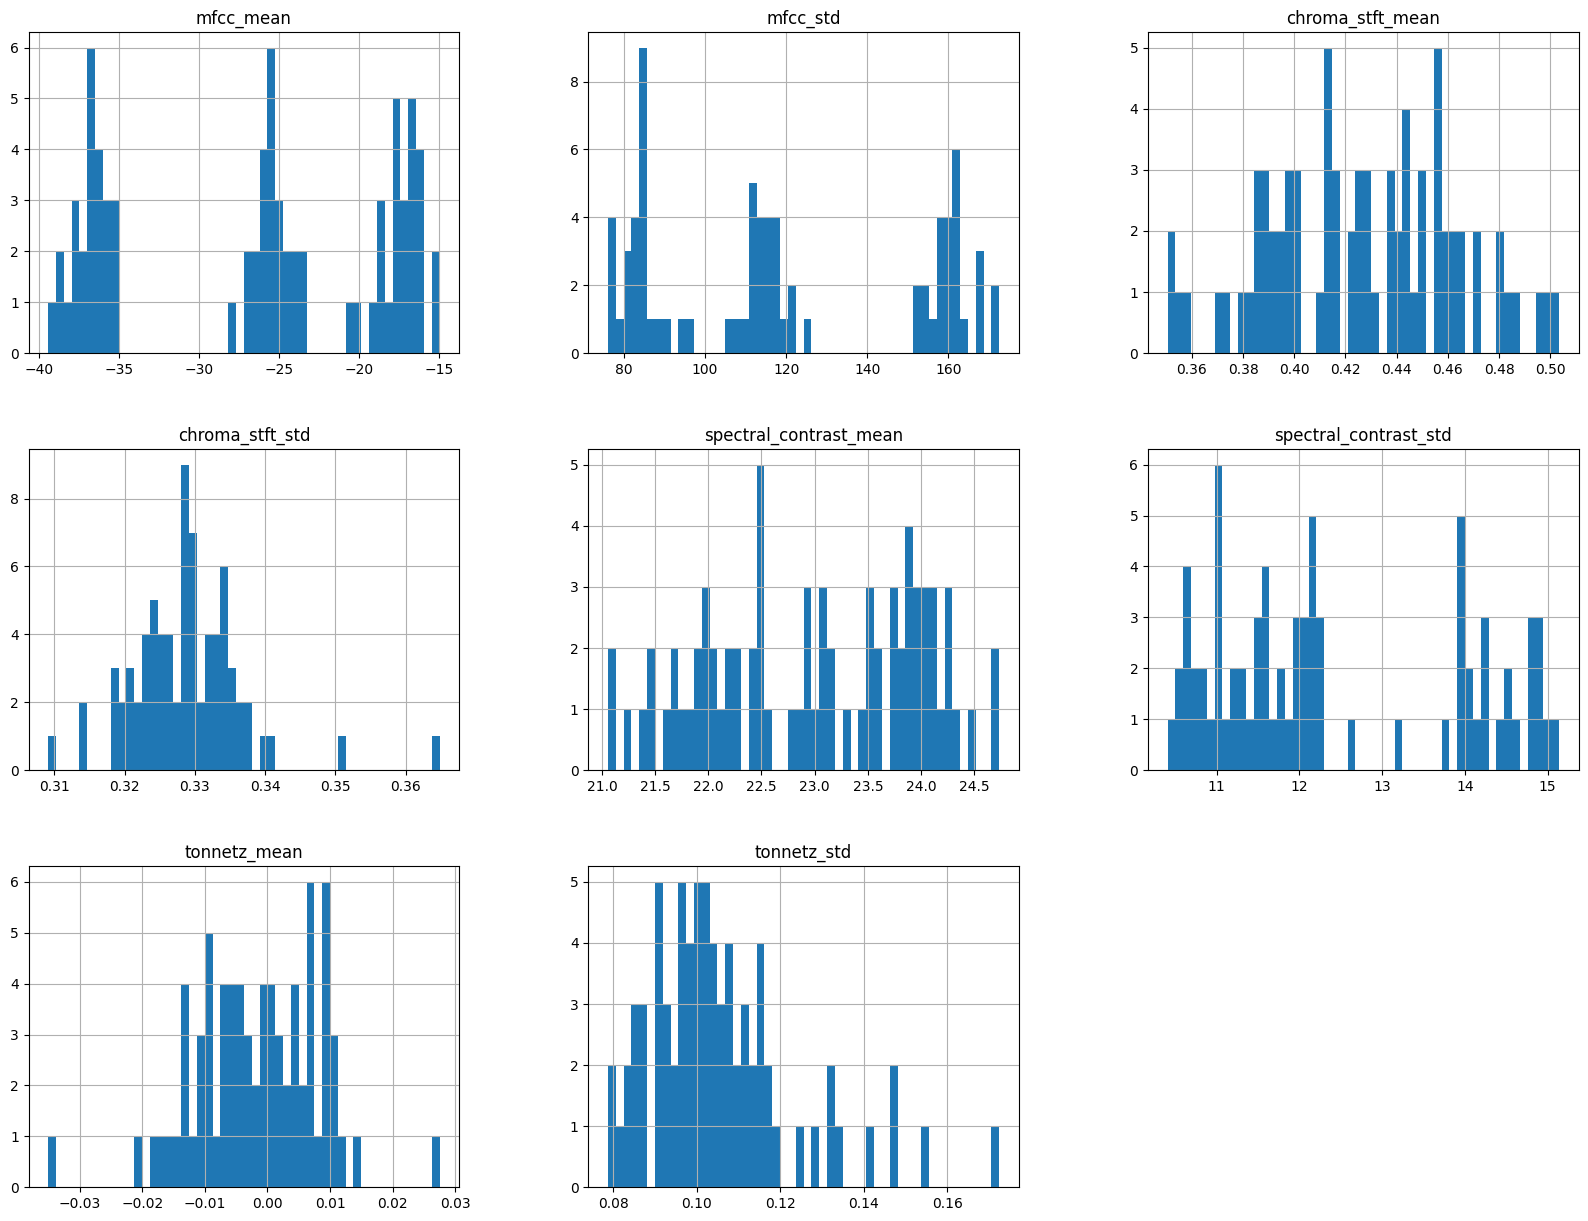

In [12]:
df[['mfcc_mean', 'mfcc_std', 'chroma_stft_mean', 'chroma_stft_std', 'spectral_contrast_mean', 'spectral_contrast_std', 'tonnetz_mean', 'tonnetz_std']].hist(bins=50, figsize=(20,15))

Now we'll plot boxplots of the extracted features for each speaker. This visualization allows us to compare the distributions of these features across different speakers. Significant differences between speakers might indicate that a certain feature could be useful for classification.

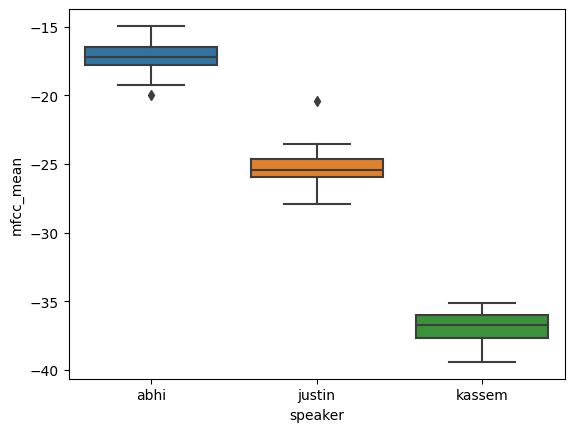

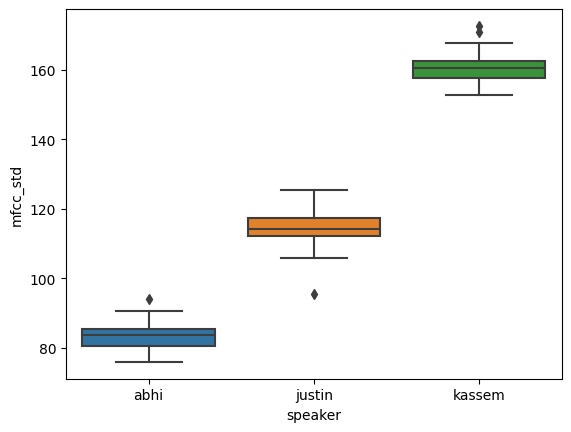

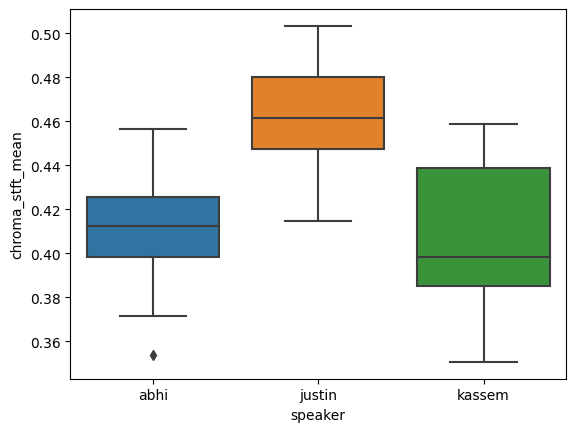

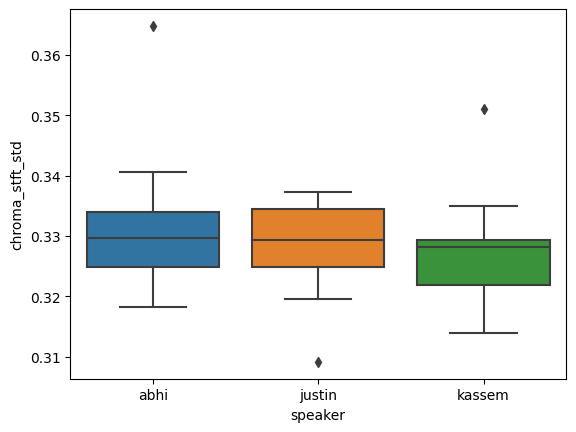

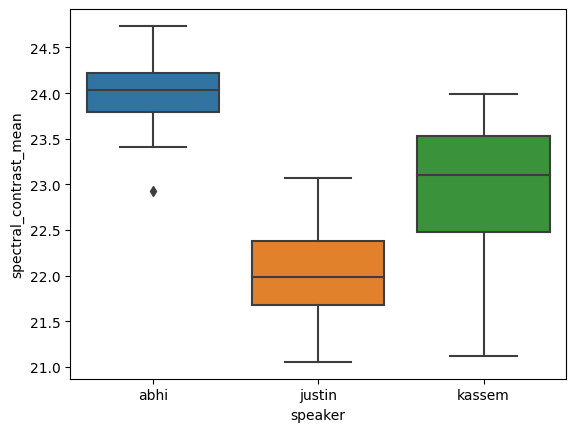

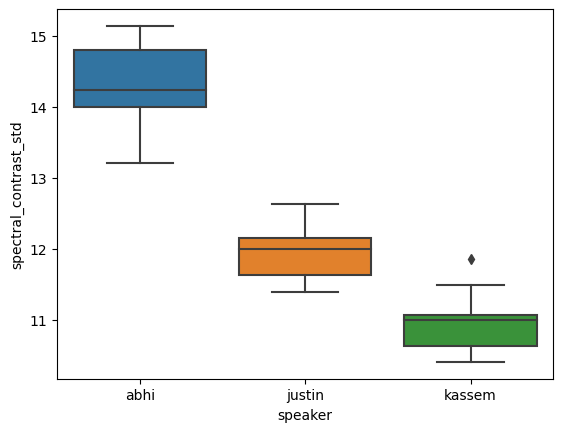

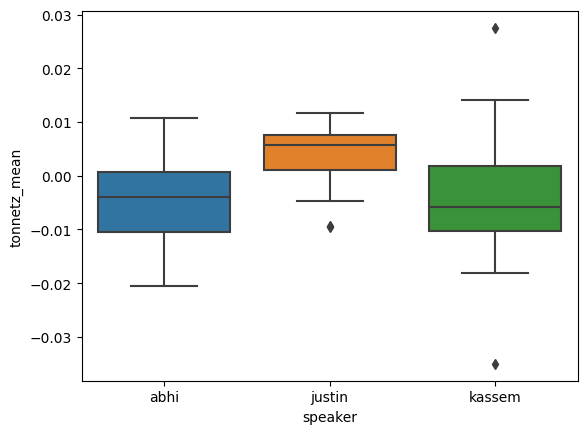

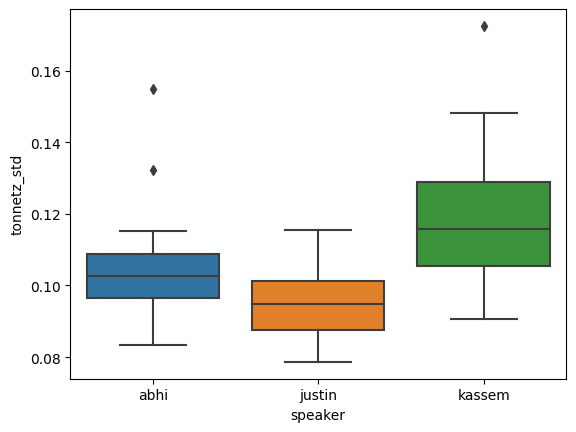

In [13]:
for col in ['mfcc_mean', 'mfcc_std', 'chroma_stft_mean', 'chroma_stft_std', 'spectral_contrast_mean', 'spectral_contrast_std', 'tonnetz_mean', 'tonnetz_std']:
    sns.boxplot(x="speaker", y=col, data=df)
    plt.show()

Now, we will calculate the correlation matrix of all numerical features. This gives us insights into which features are strongly correlated with each other. Strongly correlated features might be redundant, and knowing these correlations can help us make decisions about feature selection.

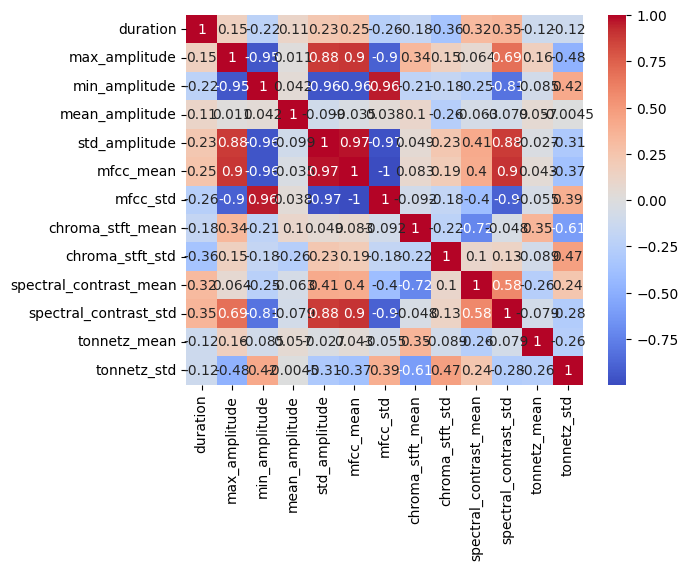

In [14]:
corrMatrix = df[['duration', 'max_amplitude', 'min_amplitude', 'mean_amplitude', 'std_amplitude', 'mfcc_mean', 'mfcc_std', 'chroma_stft_mean', 'chroma_stft_std', 'spectral_contrast_mean', 'spectral_contrast_std', 'tonnetz_mean', 'tonnetz_std']].corr()
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm')
plt.show()

**Principal Component Analysis (PCA)**

For visualization purposes, let's reduce the data to two dimensions using PCA

In [15]:
features = ['duration', 'max_amplitude', 'min_amplitude', 'mean_amplitude', 'std_amplitude', 'mfcc_mean', 'mfcc_std', 'chroma_stft_mean', 'chroma_stft_std', 'spectral_contrast_mean', 'spectral_contrast_std', 'tonnetz_mean', 'tonnetz_std']
x = df.loc[:, features].values

x = StandardScaler().fit_transform(x)

In [16]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

Now we concatenate PCA with target label for final dataframe

In [17]:
finalDf = pd.concat([principalDf, df[['speaker']]], axis = 1)

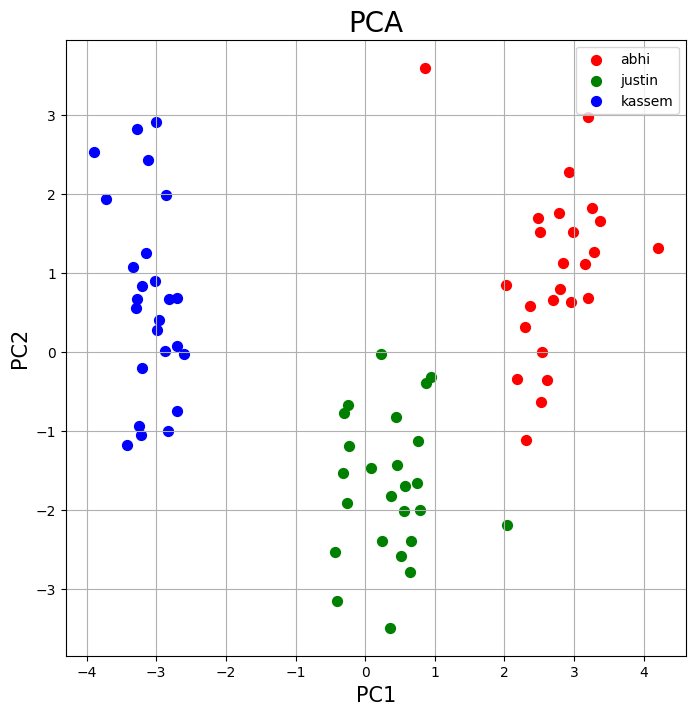

In [18]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)

targets = df['speaker'].unique()
colors = ['r', 'g', 'b']  # Change the colors accordingly based on the number of speakers

for target, color in zip(targets, colors):
    indicesToKeep = finalDf['speaker'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

**Why did we do that?**<br>
Each point on the graph corresponds to an audio file and the color of the point represents the speaker. This can help visualize how well the audio files are separated based on the speaker in the reduced feature space. If the data points from different speakers are clearly separated on the plot, it implies that the speaker could be predicted relatively accurately using these features.<br>
And luckily, that's what we have here!

## 3) Let's start the work now

We set the target as the speaker, which will be one of these 3 speakers: Justin | Kassem | Abhi

In [19]:
X=df[['raw_data', 'duration']]
y=df['speaker']

We split here the data into train and test using the train_test_split of sklearn. TEST into 20%

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
joblib.dump(label_encoder, 'model/label_encoder.joblib')

['model/label_encoder.joblib']

Here, will reshape the input data, calculate the number of classes, and shuffle the training data.

In [22]:
x_train = np.array(X_train)
x_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [23]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [24]:
num_classes = len(np.unique(y_train))
num_classes

3

In [25]:
# Reshape the input data
x_train = x_train.reshape((x_train.shape[0], 2, 1))
x_test = x_test.reshape((x_test.shape[0], 2, 1))

In [26]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

The following code defines a function `preprocess_audio` that converts raw audio data into spectrograms, applies mel-frequency scaling, and pads or crops the spectrogram to a maximum length. The function `process_audio_in_batches` processes audio data in batches by applying the `preprocess_audio` function to each batch, resulting in a processed array of spectrograms.


In [27]:
max_length = 20366
def preprocess_audio(raw_data):
    # Convert raw audio data to spectrogram
    spectrogram = librosa.feature.melspectrogram(y=raw_data, n_mels=64)
    mel_spectrogram = librosa.power_to_db(S=spectrogram, ref=np.max).astype(np.float32)  # Reduced precision to float32
    
    # Pad or crop the spectrogram to the desired length
    if mel_spectrogram.shape[1] < max_length:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_length - mel_spectrogram.shape[1])), 'constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_length]
    
    return mel_spectrogram


def process_audio_in_batches(X, batch_size=10):
    X_processed = []
    
    for i in range(0, len(X), batch_size):
        batch = X[i:i + batch_size]
        batch_processed = np.array([preprocess_audio(np.array([float(i) for i in raw_data])) for raw_data in batch['raw_data']])
        X_processed.append(batch_processed)
    
    return np.concatenate(X_processed)

The following code processes the audio data in batches using a specified batch size and assigns the processed data to new variables:

In [28]:
batch_size = 32
X_train_processed = process_audio_in_batches(X_train, batch_size=batch_size)
X_test_processed = process_audio_in_batches(X_test, batch_size=batch_size)

In [29]:
def convert_to_spectrogram(raw_data):
    spect = librosa.feature.melspectrogram(y=raw_data, n_mels=64) # n_mels as output shape
    mel_spect = librosa.power_to_db(S=spect, ref=np.max)
    return mel_spect

In [30]:
input_shape = (64, 20366)

Here's our sequential model consisting of several convolutional layers, flattening layer, and dense layers:

In [31]:
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=input_shape),
  tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
  tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
  tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(16, kernel_initializer='he_normal', activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

Let's visualize our model's architecture.

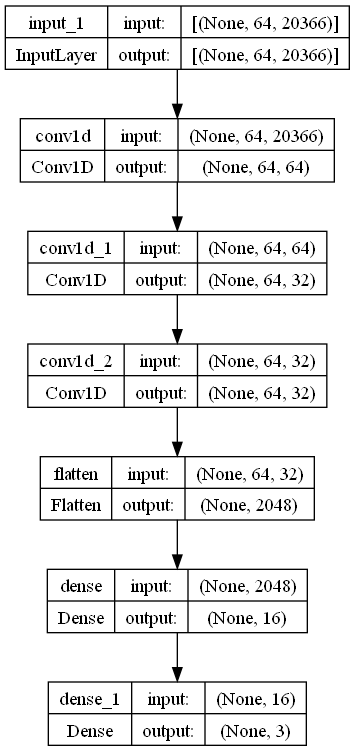

In [32]:
keras.utils.plot_model(model, show_shapes=True)

Here we will train the model using the processed training data and corresponding encoded labels<br>

Our model training process involves several important steps:

1. **ModelCheckpoint**: We save the model after each epoch. However, to conserve storage and keep only the best model, we are setting `save_best_only=True` and monitoring the `val_loss` metric. This means that the model will be saved in the path `model/model.h5` only when there is an improvement in validation loss.

2. **ReduceLROnPlateau**: We monitor the validation loss (`val_loss`), and if no improvement is seen for a certain number of epochs (`patience=20`), the learning rate is reduced by a certain factor (`factor=0.5`). This helps in getting closer to the local minimum of the loss function when the model seems to be stuck. We set a minimum limit to the learning rate (`min_lr=0.0001`) to ensure it does not get too small.

3. **EarlyStopping**: This callback ensures that the training is stopped when there is no improvement in the validation loss (`monitor='val_loss'`) for a set number of epochs (`patience=10`). This avoids unnecessary computation and potential overfitting. The `verbose=1` parameter will ensure we see log messages during the training.

4. **Model Compilation**: We configure our learning process via the compile method. Here, we are using Adam as our optimizer, Sparse Categorical Crossentropy as our loss function, and Sparse Categorical Accuracy as our evaluation metric.

5. **Model Fitting**: We then proceed to train our model for a set number of epochs (`epochs=50`) using our training data (`X_train_processed, y_train_encoded`). We set `batch_size=32`, which means the model weights will be updated after every 32 samples. We also set aside 30% of the training data for validation (`validation_split=0.3`), which helps us monitor the model's performance on unseen data during the training process.

In [33]:
epochs = 100

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "model/model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1),
]
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history = model.fit(X_train_processed, y_train_encoded, batch_size=batch_size, epochs=epochs,
                    validation_split=0.3, verbose=2)

Epoch 1/100
2/2 - 2s - loss: 7.2292 - sparse_categorical_accuracy: 0.4048 - val_loss: 28.4968 - val_sparse_categorical_accuracy: 0.1667 - 2s/epoch - 963ms/step
Epoch 2/100
2/2 - 1s - loss: 18.7795 - sparse_categorical_accuracy: 0.4048 - val_loss: 13.8454 - val_sparse_categorical_accuracy: 0.3889 - 599ms/epoch - 299ms/step
Epoch 3/100
2/2 - 1s - loss: 12.4501 - sparse_categorical_accuracy: 0.3571 - val_loss: 16.4516 - val_sparse_categorical_accuracy: 0.1667 - 624ms/epoch - 312ms/step
Epoch 4/100
2/2 - 1s - loss: 11.1024 - sparse_categorical_accuracy: 0.4762 - val_loss: 17.2340 - val_sparse_categorical_accuracy: 0.4444 - 604ms/epoch - 302ms/step
Epoch 5/100
2/2 - 1s - loss: 11.6330 - sparse_categorical_accuracy: 0.3333 - val_loss: 7.4241 - val_sparse_categorical_accuracy: 0.2222 - 627ms/epoch - 314ms/step
Epoch 6/100
2/2 - 1s - loss: 2.8071 - sparse_categorical_accuracy: 0.6190 - val_loss: 3.7357 - val_sparse_categorical_accuracy: 0.3889 - 602ms/epoch - 301ms/step
Epoch 7/100
2/2 - 1s - 

## 4) Model Evaluation

In [35]:
loss, accuracy = model.evaluate(X_test_processed, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 [==============================] - 0s 87ms/step - loss: 0.2959 - sparse_categorical_accuracy: 0.8667
Test Loss: 0.2959204614162445
Test Accuracy: 0.8666666746139526


Making predictions on new data

In [36]:
y_pred_prob = model.predict(X_test_processed)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred)

1/1 [==============================] - 0s 223ms/step


In [37]:
# Calculate classification metrics
classification_metrics = classification_report(y_test, y_pred_labels, zero_division=1)
print(classification_metrics)

              precision    recall  f1-score   support

        abhi       1.00      0.83      0.91         6
      justin       0.71      1.00      0.83         5
      kassem       1.00      0.75      0.86         4

    accuracy                           0.87        15
   macro avg       0.90      0.86      0.87        15
weighted avg       0.90      0.87      0.87        15



The precision indicates that the model performs well in correctly predicting instances for the "abhi" and "kassem" classes, with precision values of 1.00, meaning all predicted instances for these classes are correct. However, the precision for the "justin" class is slightly lower at 0.71, suggesting that there may be some false positive predictions for this class.

The recall scores highlight the model's ability to capture actual positive instances. The recall for the "justin" class is perfect at 1.00, indicating that all instances of "justin" were correctly classified. The recall for the "abhi" class is 0.83, suggesting that 83% of the actual instances of "abhi" were correctly classified. The recall for the "kassem" class is 0.75, indicating that 75% of the actual instances of "kassem" were correctly classified.

F1-score: The F1-scores provide a balanced measure of the model's performance by considering both precision and recall. The F1-score for the "abhi" class is 0.91, implying a good balance between precision and recall for this class. The F1-score for the "justin" class is 0.83, indicating a relatively good balance as well. The F1-score for the "kassem" class is 0.86, suggesting a reasonably balanced performance for this class.

Support: The support values indicate the number of occurrences of each class in the dataset. The "abhi" class has 6 instances, the "justin" class has 5 instances, and the "kassem" class has 4 instances. These support values provide insights into the distribution of classes in the dataset.

Accuracy: The accuracy score of 0.87 indicates that the model correctly classified 87% of all instances in the dataset.

In [41]:
# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[5 1 0]
 [0 5 0]
 [0 1 3]]


1 false positive prediction for the "abhi" class, while all other predictions for this class are true positives. For the "justin" class, all predictions are true positives. The "kassem" class has 1 false positive prediction, while the remaining predictions for this class are true positives.

## 5) And finally, let's save the model to use it!

In [39]:
model.save('model/model.h5')